<a href="https://colab.research.google.com/github/nahumsa/Segmentation/blob/master/Pet%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Segmentation using U-NET

This example based on the [keras.io code examples](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

# 1) Getting the images

## 1.1) Downloading

In [1]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  79.7M      0  0:00:09  0:00:09 --:--:-- 82.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  60.9M      0 --:--:-- --:--:-- --:--:-- 60.9M


## 1.2) Preparing paths for the image and the segmentation

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
num_classes = 4
batch_size = 32
#setting the image size
img_size = (160, 160)

input_img_paths = sorted(
        [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
        ]
                        )

target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
                          )

print(f"Number of samples: {len(input_img_paths)}")

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(f'input: {input_path} | target: {target_path}')

Number of samples: 7390
input: images/Abyssinian_1.jpg | target: annotations/trimaps/Abyssinian_1.png
input: images/Abyssinian_10.jpg | target: annotations/trimaps/Abyssinian_10.png
input: images/Abyssinian_100.jpg | target: annotations/trimaps/Abyssinian_100.png
input: images/Abyssinian_101.jpg | target: annotations/trimaps/Abyssinian_101.png
input: images/Abyssinian_102.jpg | target: annotations/trimaps/Abyssinian_102.png


## 1.3)Visualization of some images

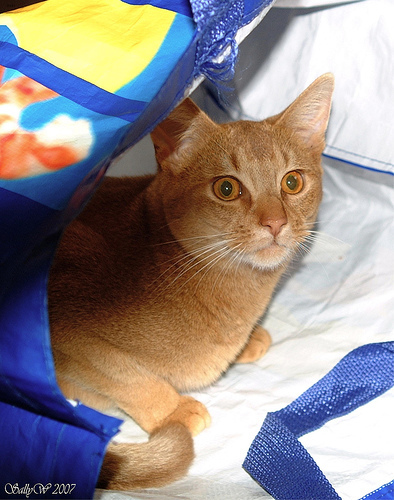

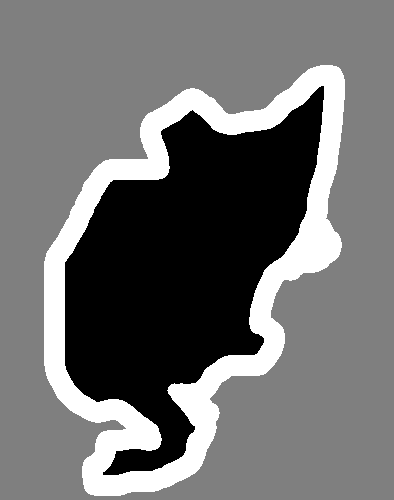

In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

index = 2
display(Image(filename=input_img_paths[index]))

# Display auto-constrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[index]))
display(img)

## 1.4) Using sequence class to load and vectorize batches

`keras.utils.sequence` is a base object for fitting to a sequence of data.

It is used the `load_img` that loads an image into the PIL format.

In [0]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

## 1.5) Setting training an testing data

We will split randomly the data into training and validation.

In [0]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, 
                       train_input_img_paths, 
                       train_target_img_paths)

val_gen = OxfordPets(batch_size, img_size, 
                     val_input_img_paths, val_target_img_paths)

# 2) Building the model

For the segmentation problem we will use the UNET with [Xception](https://arxiv.org/pdf/1610.02357.pdf) backbone.

## 2.1) UNET

In [6]:
from tensorflow.keras import layers
def set_UNET(img_size, num_classes, momentum=0.99):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization(momentum=momentum)(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = set_UNET(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 2.2) Training

In [7]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, 
          validation_data=val_gen, 
          callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 85s 427ms/step - loss: 1.0010 - val_loss: 1.7042
Epoch 2/15
199/199 [==============================] - 84s 424ms/step - loss: 0.5077 - val_loss: 2.0196
Epoch 3/15
199/199 [==============================] - 85s 427ms/step - loss: 0.4263 - val_loss: 0.4533
Epoch 4/15
199/199 [==============================] - 85s 427ms/step - loss: 0.3829 - val_loss: 0.4184
Epoch 5/15
199/199 [==============================] - 84s 422ms/step - loss: 0.3651 - val_loss: 0.4259
Epoch 6/15
199/199 [==============================] - 85s 426ms/step - loss: 0.3221 - val_loss: 0.3568
Epoch 7/15
199/199 [==============================] - 85s 426ms/step - loss: 0.2970 - val_loss: 0.3709
Epoch 8/15
199/199 [==============================] - 84s 424ms/step - loss: 0.2883 - val_loss: 0.4046
Epoch 9/15
199/199 [==============================] - 84s 423ms/step - loss: 0.2580 - val_loss: 0.3848
Epoch 10/15
199/199 [==============================] - 84s 424ms/step - l

# 3) Predictions

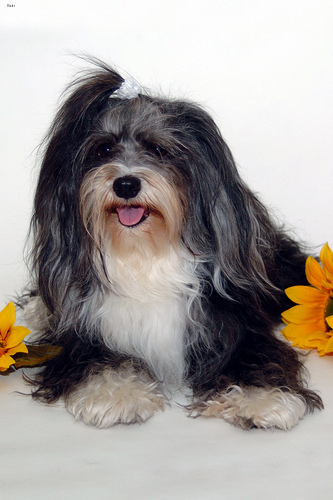

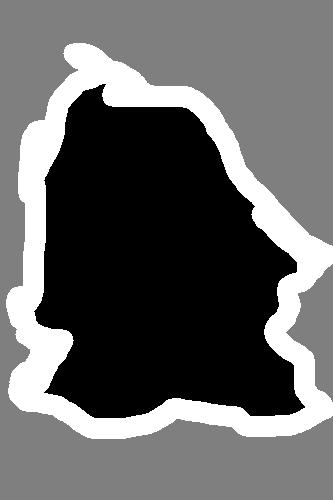

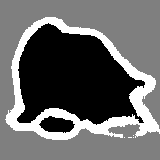

In [10]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 11

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.